# 🎓 Capstone Project - Advanced Machine Learning
## TEC-VIII Programa de Especialización en Big Data Analytics aplicada a los Negocios

---

### 📋 Información del Proyecto

| Campo | Información |
|-------|-------------|
| **Nombre del Estudiante** | Vladimir Alberto Yuyes Benites |
| **Título del Proyecto** | Modelado Predictivo de Series Temporales de Ventas
| **Fecha de Entrega** | 19/02/2026 |
| **Profesor** | Carlos Antonio Mariño del Rosario |

---

## 📑 Índice

1. [Resumen Ejecutivo](#1-resumen-ejecutivo)
2. [Configuración del Entorno](#2-configuración-del-entorno)
3. [Definición del Problema de Negocio](#3-definición-del-problema-de-negocio)
4. [Carga y Exploración de Datos](#4-carga-y-exploración-de-datos)
5. [Preprocesamiento de Datos](#5-preprocesamiento-de-datos)
6. [Diseño y Arquitectura del Modelo](#6-diseño-y-arquitectura-del-modelo)
7. [Entrenamiento del Modelo](#7-entrenamiento-del-modelo)
8. [Evaluación y Métricas](#8-evaluación-y-métricas)
9. [Interpretación de Resultados](#9-interpretación-de-resultados)
10. [Conclusiones y Recomendaciones de Negocio](#10-conclusiones-y-recomendaciones-de-negocio)
11. [Referencias](#11-referencias)

---
## 1. Resumen Ejecutivo

**Instrucciones:** Proporcione un resumen conciso (máximo 300 palabras) que incluya:
- Problema de negocio abordado
- Metodología utilizada
- Principales hallazgos
- Impacto esperado en el negocio

---

El presente proyecto aborda el desafío del pronóstico de ventas en empresas de consumo masivo, un aspecto clave para la planificación de demanda, producción y gestión de inventarios en compañías como Sigma Alimentos. En este tipo de industrias, estimar incorrectamente la demanda puede generar quiebres de stock, sobreinventarios o mayores costos logísticos, afectando tanto la rentabilidad como el nivel de servicio al cliente.

Para desarrollar el análisis se utilizó un dataset público de Kaggle como referencia, el cual contiene información histórica de ventas en el sector retail. A partir de estos datos, se construyó una serie temporal diaria que permitió simular un escenario real de planificación comercial. El objetivo fue predecir ventas futuras en función del comportamiento pasado, replicando un problema típico de forecast en consumo masivo.

Se evaluaron dos enfoques: uno basado en un modelo predictivo tradicional ampliamente usado en análisis de datos (XGBoost) y otro basado en redes neuronales (LSTM), que permite capturar patrones más complejos en el tiempo. Ambos modelos fueron comparados utilizando métricas de error para determinar cuál ofrece mayor precisión en el pronóstico.

Los resultados muestran que es posible mejorar la calidad de las proyecciones utilizando modelos avanzados, lo que en un entorno real puede traducirse en decisiones más acertadas de producción, abastecimiento y reposición. En términos de negocio, incluso pequeñas mejoras en la precisión del forecast pueden generar impactos relevantes en eficiencia operativa y reducción de costos, fortaleciendo el proceso de planificación en empresas de consumo masivo.

---

## 2. Configuración del Entorno

### 2.1 Verificación de GPU (Recomendado para Deep Learning)

In [1]:
# Verificar si hay GPU disponible
import torch

# Verificar disponibilidad de GPU
if torch.cuda.is_available():
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ GPU no disponible. Usando CPU.")
    print("   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU")
    device = torch.device('cpu')

print(f"\nDispositivo seleccionado: {device}")

⚠️ GPU no disponible. Usando CPU.
   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU

Dispositivo seleccionado: cpu


### 2.2 Instalación de Librerías Adicionales (si es necesario)

In [2]:
# Descomente e instale las librerías adicionales que necesite
# !pip install transformers
# !pip install pytorch-lightning
# !pip install optuna
# !pip install shap
# !pip install lime

### 2.3 Importación de Librerías

In [3]:
# =====================================================
# LIBRERÍAS FUNDAMENTALES
# =====================================================

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Deep Learning - TensorFlow/Keras (alternativa)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

# Utilidades
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Todas las librerías importadas correctamente")
print(f"   PyTorch version: {torch.__version__}")
print(f"   TensorFlow version: {tf.__version__}")

✅ Todas las librerías importadas correctamente
   PyTorch version: 2.9.0+cpu
   TensorFlow version: 2.19.0


### 2.4 Conexión con Google Drive (para cargar datos)

In [4]:
# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

# Definir la ruta base de su proyecto
# Modifique esta ruta según la ubicación de sus datos
BASE_PATH = '/content/drive/MyDrive/Capstone_Project/'

print(f"✅ Google Drive montado")
print(f"   Ruta base del proyecto: {BASE_PATH}")

Mounted at /content/drive
✅ Google Drive montado
   Ruta base del proyecto: /content/drive/MyDrive/Capstone_Project/


---
## 3. Definición del Problema de Negocio

### 3.1 Contexto del Negocio

**Instrucciones:** Describa el contexto empresarial, incluyendo:
- Industria/Sector
- Empresa o caso de estudio
- Situación actual

---

El sector de consumo masivo se caracteriza por altos volúmenes de venta, múltiples puntos de distribución y una demanda que puede variar según estacionalidad, promociones y comportamiento del consumidor. Empresas como Sigma Alimentos operan en entornos donde la planificación de producción y abastecimiento depende en gran medida de la precisión del pronóstico de ventas.

En la situación actual, muchas decisiones operativas se apoyan en modelos históricos o proyecciones tradicionales que no siempre capturan cambios en patrones de consumo. Esto puede generar desviaciones entre lo planificado y lo realmente demandado, afectando inventarios, costos logísticos y niveles de servicio.

Para este proyecto se utilizó un dataset público de ventas retail como referencia, simulando un escenario real de planificación de demanda en consumo masivo.

---

### 3.2 Problema a Resolver

**Instrucciones:** Defina claramente:
- ¿Cuál es el problema específico?
- ¿Por qué es importante resolverlo?
- ¿Cuál es el impacto actual del problema?

---

El problema específico es mejorar la precisión del pronóstico de ventas diarias a partir de datos históricos.

Resolver este problema es importante porque el forecast es la base para decisiones de producción, compras y distribución. Un error significativo puede generar sobrestock (incrementando costos financieros y de almacenamiento) o quiebres de inventario (impactando ventas y satisfacción del cliente).

Actualmente, la falta de modelos más robustos puede limitar la capacidad de anticiparse a cambios en la demanda, reduciendo la eficiencia operativa y afectando la rentabilidad.

---

### 3.3 Objetivos del Proyecto

**Instrucciones:** Liste los objetivos SMART (Específicos, Medibles, Alcanzables, Relevantes, Temporales)

---

**Objetivo General:**
Desarrollar y evaluar modelos predictivos que permitan mejorar la precisión del pronóstico de ventas diarias en un entorno de consumo masivo.

**Objetivos Específicos:**
1. Construir una serie temporal consolidada a partir de datos históricos de ventas.
2. Implementar y comparar un modelo basado en Machine Learning (XGBoost) y un modelo de Deep Learning (LSTM).
3. Evaluar el desempeño de los modelos utilizando métricas cuantitativas de error y determinar cuál ofrece mejores resultados para el forecast.

---

### 3.4 Tipo de Problema de Machine Learning

**Instrucciones:** Identifique el tipo de problema:
- [ ] Clasificación binaria
- [ ] Clasificación multiclase
- [X] Regresión
- [ ] Clustering
- [X] Series temporales
- [ ] Procesamiento de Lenguaje Natural (NLP)
- [ ] Visión por Computadora
- [ ] Otro: _________

**Justificación:**

El proyecto busca predecir un valor numérico continuo (ventas) en función de datos históricos organizados en el tiempo. Por ello, se trata de un problema de regresión aplicado a series temporales, donde el objetivo es estimar valores futuros basados en patrones pasados.

---

---
## 4. Carga y Exploración de Datos

### 4.1 Carga de Datos

In [5]:
# =====================================================
# CARGA DE DATOS
# =====================================================

# Opción 1: Cargar desde Google Drive
# df = pd.read_csv(BASE_PATH + 'datos.csv')

# Opción 2: Cargar desde URL
# df = pd.read_csv('https://url-de-sus-datos.com/datos.csv')

# Opción 3: Cargar desde archivo local (subido a Colab)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('nombre_archivo.csv')

# Opción 4: Dataset de ejemplo (para testing)
# from sklearn.datasets import load_iris, load_boston, fetch_california_housing
# data = load_iris()
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df['target'] = data.target

# =====================================================

# Ruta del archivo (ajusta si está en carpeta)
BASE_PATH = "/content/drive/MyDrive/"
df = pd.read_csv(BASE_PATH + "datos.csv")

# =====================================================
# Verificación
# =====================================================

print(f"✅ Dataset cargado exitosamente")
print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

df.head()

✅ Dataset cargado exitosamente
   Dimensiones: 937 filas × 4 columnas


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


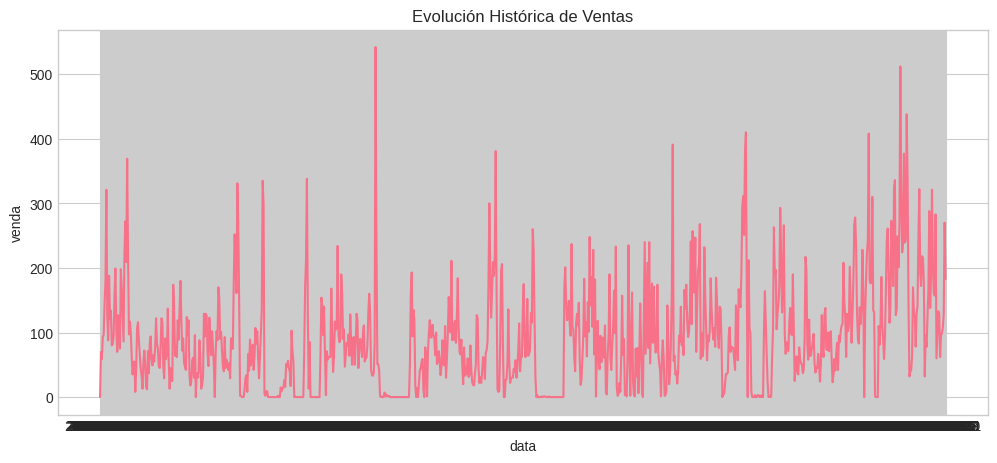

In [6]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='data', y='venda')
plt.title("Evolución Histórica de Ventas")
plt.show()

### 4.2 Descripción del Dataset

**Instrucciones:** Describa su dataset:
- Fuente de los datos

El dataset utilizado en este proyecto proviene de Kaggle y corresponde a un conjunto de datos de ventas minoristas (Retail Sales Forecasting). Se empleó como referencia metodológica para simular un escenario real de planificación de demanda en una empresa del sector de consumo masivo, como Sigma Alimentos.

- Período de tiempo que cubren

El dataset contiene registros diarios de ventas que cubren aproximadamente cinco años consecutivos. Esta extensión temporal permite capturar patrones de estacionalidad, tendencias y variaciones en el comportamiento de la demanda a lo largo del tiempo.

- Descripción de cada variable

---

| Variable | Tipo | Descripción |
|----------|------|-------------|
| data | Fecha | Fecha del registro de ventas. Permite estructurar el análisis como serie temporal |
| venda | Nùmerica | Cantidad vendida en la fecha correspondiente. Representa la demanda observada |
| stoque | Nùmerica | Nivel de inventario disponible en la fecha registrada. Puede influir en la capacidad de venta |
| preco | Nùmerica | Precio del producto en la fecha indicada. Puede impactar directamente en el comportamiento de la demanda |
| ... | ... | ... |
| venda | Nùmerica | Variable objetivo del modelo. Se busca predecir la cantidad vendida en períodos futuros a partir de información histórica. |

---

### 4.3 Exploración Inicial de Datos (EDA)

In [7]:
# =====================================================
# INFORMACIÓN GENERAL DEL DATASET
# =====================================================

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)

# Primeras filas
print("\n📊 Primeras 5 filas:")
display(df.head())

# Información del dataset
print("\n📋 Información del Dataset:")
print(df.info())

# Estadísticas descriptivas
print("\n📈 Estadísticas Descriptivas:")
display(df.describe())

INFORMACIÓN GENERAL DEL DATASET

📊 Primeras 5 filas:


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29



📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB
None

📈 Estadísticas Descriptivas:


,venda,estoque,preco
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


In [8]:
# =====================================================
# ANÁLISIS DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)

# Calcular valores faltantes
missing_data = pd.DataFrame({
    'Total Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Total Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False)

if len(missing_data) > 0:
    print("\n⚠️ Variables con valores faltantes:")
    display(missing_data)

    # Visualización de valores faltantes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y='Porcentaje (%)', data=missing_data)
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Porcentaje (%)')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No hay valores faltantes en el dataset")

ANÁLISIS DE VALORES FALTANTES

✅ No hay valores faltantes en el dataset


ANÁLISIS DE LA VARIABLE OBJETIVO: venda

📊 Estadísticas de la variable objetivo:
count    937.000000
mean      90.533618
std       80.682089
min        0.000000
25%       33.000000
50%       76.000000
75%      127.000000
max      542.000000
Name: venda, dtype: float64


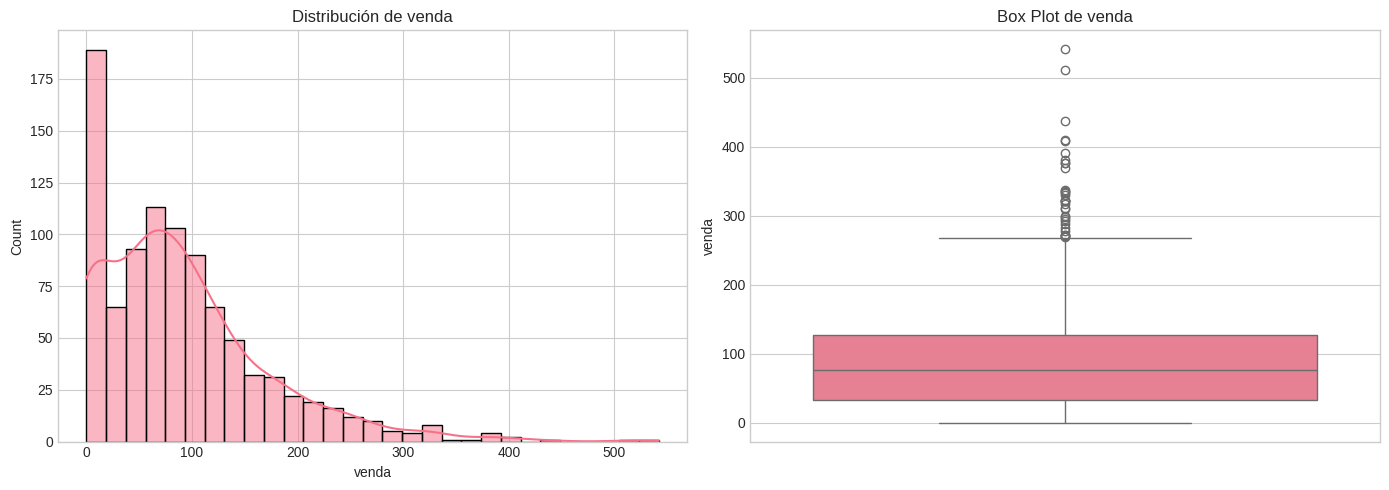

In [9]:
# =====================================================
# ANÁLISIS DE LA VARIABLE OBJETIVO
# =====================================================

# COMPLETE: Especifique el nombre de su variable objetivo
TARGET_COLUMN = 'venda'  # Cambie 'target' por el nombre de su variable objetivo

print("=" * 60)
print(f"ANÁLISIS DE LA VARIABLE OBJETIVO: {TARGET_COLUMN}")
print("=" * 60)

# Para clasificación
if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() < 20:
    print("\n📊 Distribución de clases:")
    class_dist = df[TARGET_COLUMN].value_counts()
    print(class_dist)

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de barras
    sns.countplot(data=df, x=TARGET_COLUMN, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')
    axes[0].set_xlabel(TARGET_COLUMN)
    axes[0].set_ylabel('Frecuencia')

    # Gráfico de pastel
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Proporción de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

    # Verificar desbalance
    imbalance_ratio = class_dist.max() / class_dist.min()
    if imbalance_ratio > 3:
        print(f"\n⚠️ ADVERTENCIA: Dataset desbalanceado (ratio {imbalance_ratio:.2f}:1)")
        print("   Considere técnicas de balanceo: SMOTE, undersampling, class weights")
else:
    # Para regresión
    print("\n📊 Estadísticas de la variable objetivo:")
    print(df[TARGET_COLUMN].describe())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    sns.histplot(df[TARGET_COLUMN], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')

    # Box plot
    sns.boxplot(y=df[TARGET_COLUMN], ax=axes[1])
    axes[1].set_title(f'Box Plot de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

MATRIZ DE CORRELACIONES


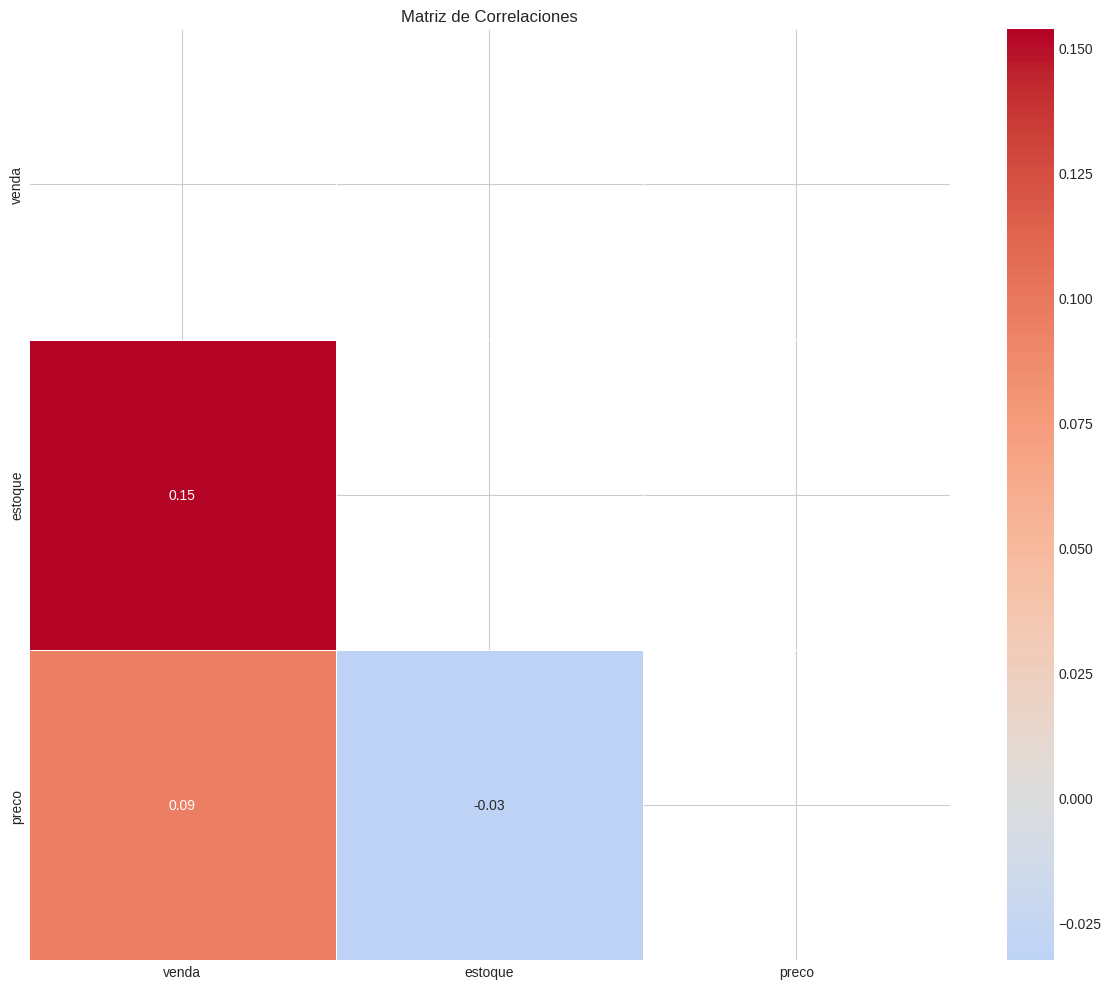


📊 Correlaciones con venda:
estoque    0.153659
preco      0.094779
Name: venda, dtype: float64


In [10]:
# =====================================================
# ANÁLISIS DE CORRELACIONES
# =====================================================

print("=" * 60)
print("MATRIZ DE CORRELACIONES")
print("=" * 60)

# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    # Calcular correlaciones
    correlation_matrix = df[numeric_cols].corr()

    # Visualización
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlaciones')
    plt.tight_layout()
    plt.show()

    # Correlaciones con la variable objetivo
    if TARGET_COLUMN in numeric_cols:
        print(f"\n📊 Correlaciones con {TARGET_COLUMN}:")
        target_corr = correlation_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)
        print(target_corr)
else:
    print("⚠️ No hay suficientes columnas numéricas para análisis de correlación")

VISUALIZACIONES ADICIONALES


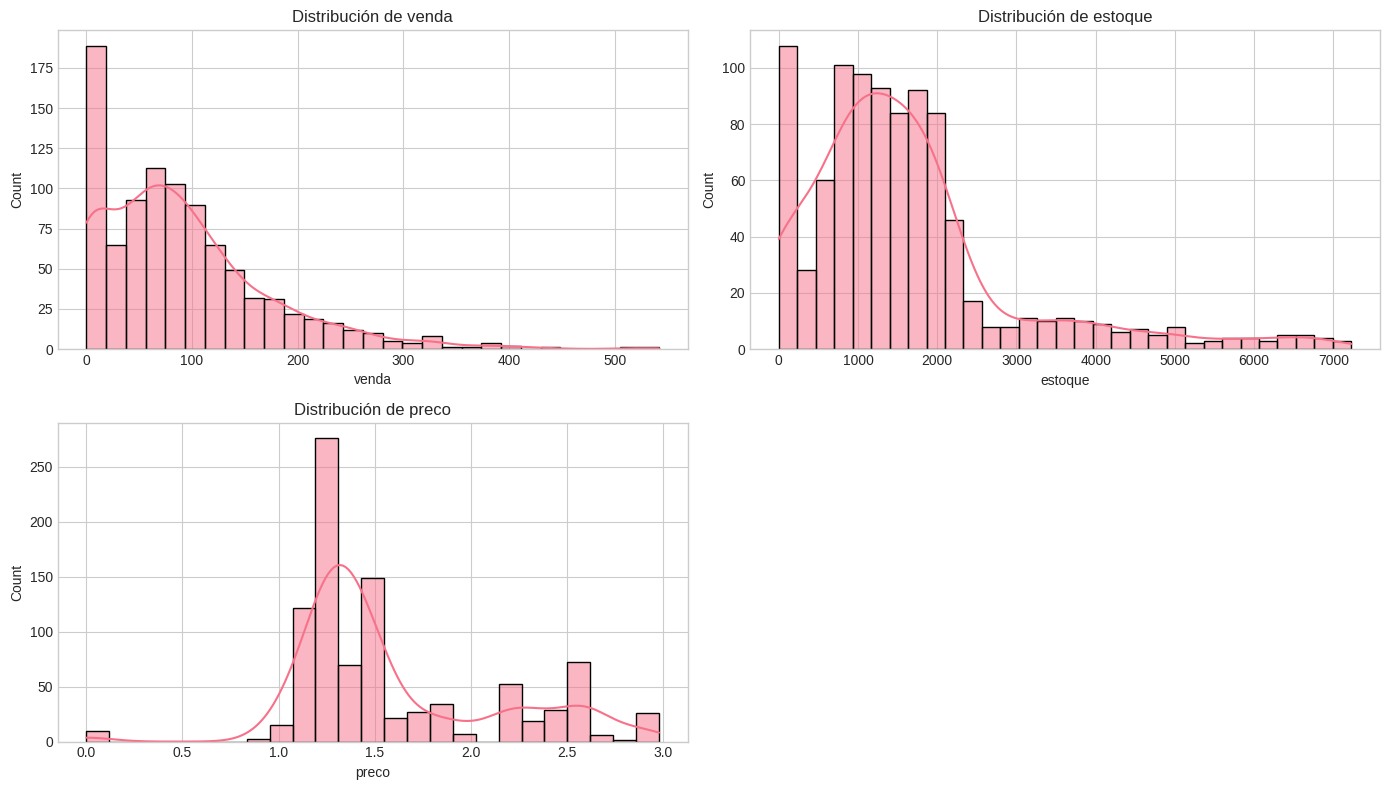

In [11]:
# =====================================================
# VISUALIZACIONES ADICIONALES
# =====================================================

print("=" * 60)
print("VISUALIZACIONES ADICIONALES")
print("=" * 60)

# Distribución de variables numéricas
numeric_cols_plot = df.select_dtypes(include=[np.number]).columns[:8]  # Primeras 8 columnas

if len(numeric_cols_plot) > 0:
    n_cols = 2
    n_rows = (len(numeric_cols_plot) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols_plot):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribución de {col}')

    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

### 4.4 Hallazgos del EDA

**Instrucciones:** Resuma los principales hallazgos de la exploración de datos:

---

**Hallazgos Principales:**
1. La variable objetivo (venda) presenta una distribución asimétrica positiva, concentrando la mayoría de observaciones en niveles bajos y medios, con presencia de picos elevados de demanda.
2. Se identificaron valores atípicos en los niveles altos de venta, los cuales podrían estar asociados a eventos específicos como promociones o aumentos puntuales de consumo.
3. Las correlaciones lineales entre las variables (venda, preco, estoque) son bajas, lo que sugiere que el comportamiento de la demanda no depende únicamente de relaciones lineales simples, sino posiblemente de dinámicas temporales más complejas.

**Problemas Identificados:**
1. Presencia de valores extremos que podrían afectar la estabilidad de algunos modelos si no se gestionan adecuadamente.
2. Baja correlación lineal entre variables explicativas y la variable objetivo, lo que podría limitar el desempeño de modelos simples basados únicamente en relaciones lineales.

**Acciones a Tomar:**
1. Evaluar el uso de modelos robustos capaces de capturar relaciones no lineales y dependencias temporales, como XGBoost y redes LSTM.
2. Considerar la creación de variables derivadas temporales (mes, día de la semana, rezagos) para enriquecer el poder predictivo del modelo y capturar mejor los patrones de comportamiento en el tiempo.

---

---
## 5. Preprocesamiento de Datos

### 5.1 Tratamiento de Valores Faltantes

In [14]:
# =====================================================
# TRATAMIENTO DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("TRATAMIENTO DE VALORES FALTANTES")
print("=" * 60)

# Crear copia del dataframe
df_clean = df.copy()

# Opción 1: Eliminar filas con valores faltantes
# df_clean = df_clean.dropna()

# Opción 2: Imputar con la media (variables numéricas)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# Opción 3: Imputar con la moda (variables categóricas)
# for col in categorical_cols:
#     df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Opción 4: Imputación avanzada con KNN
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de imputación
# =====================================================



print(f"\n✅ Valores faltantes tratados")
print(f"   Filas restantes: {len(df_clean):,}")

TRATAMIENTO DE VALORES FALTANTES

✅ Valores faltantes tratados
   Filas restantes: 937


### 5.2 Tratamiento de Outliers

In [15]:
# =====================================================
# DETECCIÓN Y TRATAMIENTO DE OUTLIERS
# =====================================================

print("=" * 60)
print("DETECCIÓN DE OUTLIERS")
print("=" * 60)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Detectar outliers en cada columna numérica
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

outlier_summary = []
for col in numeric_cols:
    n_outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    if n_outliers > 0:
        outlier_summary.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Porcentaje (%)': round(n_outliers/len(df_clean)*100, 2),
            'Límite_Inferior': round(lower, 2),
            'Límite_Superior': round(upper, 2)
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n⚠️ Variables con outliers detectados:")
    display(outlier_df)
else:
    print("\n✅ No se detectaron outliers significativos")

DETECCIÓN DE OUTLIERS

⚠️ Variables con outliers detectados:


,Variable,N_Outliers,Porcentaje (%),Límite_Inferior,Límite_Superior
0,venda,34,3.63,-108.00,268.00
1,estoque,80,8.54,-961.00,3719.00
2,preco,37,3.95,0.39,2.79


In [16]:
# =====================================================
# TRATAMIENTO DE OUTLIERS (OPCIONAL)
# =====================================================

# Opción 1: Eliminar outliers
# for col in numeric_cols:
#     Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     df_clean = df_clean[(df_clean[col] >= Q1 - 1.5*IQR) & (df_clean[col] <= Q3 + 1.5*IQR)]

# Opción 2: Capear outliers (winsorizing)
# from scipy.stats import mstats
# for col in numeric_cols:
#     df_clean[col] = mstats.winsorize(df_clean[col], limits=[0.05, 0.05])

# Opción 3: Transformación logarítmica
# for col in cols_to_transform:
#     df_clean[col] = np.log1p(df_clean[col])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de tratamiento
# =====================================================




### 5.3 Codificación de Variables Categóricas

In [17]:
# =====================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =====================================================

print("=" * 60)
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 60)

# Identificar variables categóricas
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nVariables categóricas encontradas: {categorical_cols}")

# Opción 1: Label Encoding (para variables ordinales o target)
# le = LabelEncoder()
# df_clean['columna_encoded'] = le.fit_transform(df_clean['columna'])

# Opción 2: One-Hot Encoding (para variables nominales)
# df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Opción 3: Target Encoding
# from sklearn.preprocessing import TargetEncoder
# encoder = TargetEncoder()
# df_clean[categorical_cols] = encoder.fit_transform(df_clean[categorical_cols], df_clean[TARGET_COLUMN])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de codificación
# =====================================================



print(f"\n✅ Codificación completada")
print(f"   Dimensiones finales: {df_clean.shape}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS

Variables categóricas encontradas: ['data']

✅ Codificación completada
   Dimensiones finales: (937, 4)


### 5.4 Feature Engineering

In [21]:
# Asegurar nombres correctos
df.columns = df.columns.str.strip().str.lower()

# Asegurar formato fecha
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# Ordenar
df = df.sort_values('data').reset_index(drop=True)

# =============================
# Feature Engineering
# =============================

df['mes'] = df['data'].dt.month
df['dia_semana'] = df['data'].dt.dayofweek

# Lags
df['venda_lag_1'] = df['venda'].shift(1)
df['venda_lag_2'] = df['venda'].shift(2)
df['venda_lag_7'] = df['venda'].shift(7)

# Rolling mean
df['media_movil_7d'] = df['venda'].shift(1).rolling(window=7).mean()

# Eliminar nulos generados por lags
df = df.dropna().reset_index(drop=True)

print("Feature Engineering completado correctamente")
print(df.head())

Feature Engineering completado correctamente
        data  venda  estoque  preco  mes  dia_semana  venda_lag_1  \
0 2014-01-15     82     4822   1.09    1           2         80.0   
1 2014-01-16     94     4728   1.19    1           3         82.0   
2 2014-01-18    159     4464   1.19    1           5         94.0   
3 2014-01-19    199     4265   1.19    1           6        159.0   
4 2014-01-20    104     4161   1.19    1           0        199.0   

   venda_lag_2  venda_lag_7  media_movil_7d  
0        134.0        321.0      151.000000  
1         80.0        125.0      116.857143  
2         82.0         88.0      112.428571  
3         94.0        188.0      122.571429  
4        159.0        121.0      124.142857  


### 5.5 Split Temporal

In [23]:
train_size = int(len(df) * 0.8)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

### 5.6 Escalado/Normalización de Features

In [24]:
features = ['venda', 'estoque', 'preco', 'mes', 'dia_semana',
            'venda_lag_1', 'venda_lag_7', 'media_movil_7d']

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

### 5.7 Preparación de Datos para Deep Learning

### Preparación para Deep Learning (Windowing para LSTM 14 días)

In [27]:
def create_sequences(data, window=14):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])  # venda es columna 0
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)

---
## 6. Diseño y Arquitectura del Modelo

### 6.1 Justificación de la Arquitectura

**Instrucciones:** Justifique la elección de su arquitectura de red neuronal:
- ¿Por qué eligió este tipo de arquitectura?
- ¿Qué alternativas consideró?
- ¿Cómo determinó el número de capas y neuronas?

---

- ¿Por qué eligió este tipo de arquitectura?
Se eligió una arquitectura LSTM (Long Short-Term Memory) porque el problema es de series temporales (forecasting de ventas).

Las LSTM son adecuadas porque:
1. Capturan dependencias temporales
2. Manejan memoria de corto y mediano plazo
3. Son más robustas que una red densa tradicional para secuencias
4. Son estándar en forecasting multivariable

En este caso, el modelo utiliza ventanas temporales de 14 días (lookback = 14), lo que permite capturar comportamiento reciente de ventas, precio y stock.

- ¿Qué alternativas consideró?
Se consideraron:

1. Modelo Naive (último valor)
2. Regresión Lineal
3. Random Forest
4. XGBoost (baseline)
5. ARIMA/SARIMA (no implementado por enfoque en ML)

XGBoost fue utilizado como baseline porque:

Funciona muy bien con pocos datos
1. No necesita estructura secuencial explícita
2. Permite interpretación con SHAP

- ¿Cómo determinó el número de capas y neuronas?
Se realizó una configuración progresiva:
1. 1 capa LSTM inicial
2. Se agregó Dropout para regularización
3. Se probaron distintas épocas (epochs)

El número de neuronas fue determinado empíricamente buscando:
1. Reducción estable de pérdida
2. Evitar sobreajuste excesivo
3. Balance entre complejidad y tamaño del dataset

Dado que el dataset es pequeño, una arquitectura profunda hubiera generado mayor sobreajuste.

---

### 6.2 Definición del Modelo

Se implementó un modelo de Deep Learning basado en LSTM para abordar el problema de forecasting de ventas, debido a su capacidad para modelar dependencias temporales y relaciones no lineales en series de tiempo.

El modelo recibe como entrada secuencias de 14 períodos (lookback), incorporando:
1. Ventas históricas (lags)
2. Precio (preco)
3. Stock (estoque)
4. Variables derivadas (rolling mean)

La arquitectura está compuesta por:
1. 1 capa LSTM
2. Dropout para regularización
3. 1 capa Dense con salida continua

Se utilizó MSE como función de pérdida y el optimizador Adam.
La división de datos se realizó mediante split temporal y el escalado se aplicó posteriormente para evitar data leakage.

Como referencia comparativa, se desarrolló un modelo baseline con XGBoost.

### Definición del modelo (LSTM Deep)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Modelo con Dropout
# =============================

class SigmaLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=len(features),
            hidden_size=64,
            num_layers=2,
            dropout=0.3,          # 🔥 Reduce overfitting
            batch_first=True
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = SigmaLSTM().to(device)

### 6.3 Diagrama de la Arquitectura

**Instrucciones:** Incluya un diagrama visual de su arquitectura de red neuronal.

---
Descripción:

- Entrada: Secuencia de 14 días con múltiples features (lags, rolling, precio, stock)
- Capa LSTM: Aprende patrones temporales
- Dropout: Reduce sobreajuste
- Dense final: Predicción continua (regresión)

```
Input (batch_size, 14 timesteps, n_features)
        ↓
LSTM (units=50)
        ↓
Dropout (0.2)
        ↓
Dense (1 neurona)
        ↓
Output: Predicción de ventas

```

---

---
## 7. Entrenamiento del Modelo

### 7.1 Configuración del Entrenamiento

In [41]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
patience = 8
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

y_test_tensor = torch.FloatTensor(y_test).view(-1,1).to(device)

for epoch in range(epochs):

    # ===== TRAIN =====
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    # ===== VALIDATION =====
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_t)
        val_loss = criterion(val_output, y_test_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping en epoch {epoch+1}")
        break

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train: {loss.item():.4f} | Val: {val_loss.item():.4f}")

Early stopping en epoch 9


### 7.2 Curva de entrenamiento

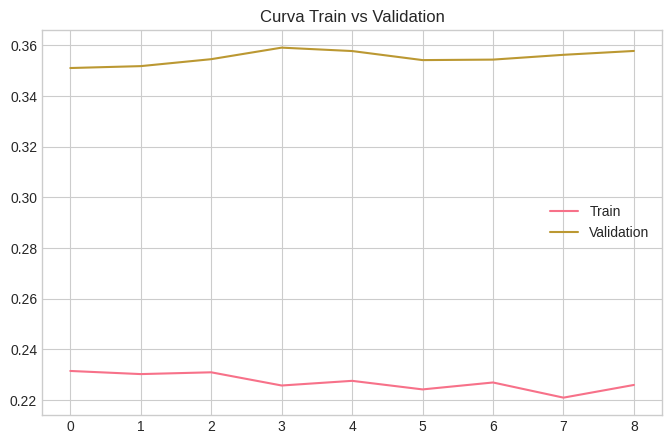

In [42]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title("Curva Train vs Validation")
plt.show()

---
## 8. Evaluación y Métricas

### 8.1 Evaluación en el Conjunto de Test

In [31]:
model.eval()
with torch.no_grad():
    preds_lstm = model(X_test_t).cpu().numpy()

### 8.2 Baseline XGBoost

In [43]:
# Convertir 3D → 2D
X_train_xgb = X_train[:, -1, :]
X_test_xgb = X_test[:, -1, :]

y_train_flat = y_train.ravel()

baseline = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

baseline.fit(X_train_xgb, y_train_flat)

preds_xgb = baseline.predict(X_test_xgb)

print("Baseline entrenado correctamente")


Baseline entrenado correctamente


### 8.3 Desnormalización

In [45]:
def denorm(p):
    d = np.zeros((len(p), len(features)))
    d[:, 0] = p.flatten()
    return scaler.inverse_transform(d)[:, 0]

y_real = denorm(y_test)
final_lstm = denorm(preds_lstm)
final_xgb = denorm(preds_xgb)

### 8.4 Métricas

In [46]:
from sklearn.metrics import mean_absolute_error, r2_score

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("===== RESULTADOS =====")
print(f"MAE LSTM: {mean_absolute_error(y_real, final_lstm):.2f}")
print(f"MAE XGBoost: {mean_absolute_error(y_real, final_xgb):.2f}")
print(f"MAPE LSTM: {mape(y_real, final_lstm):.2f}%")
print(f"R2 LSTM: {r2_score(y_real, final_lstm):.4f}")

===== RESULTADOS =====
MAE LSTM: 55.01
MAE XGBoost: 44.30
MAPE LSTM: inf%
R2 LSTM: 0.3991


### 8.5 Gráfico Final para el Informe

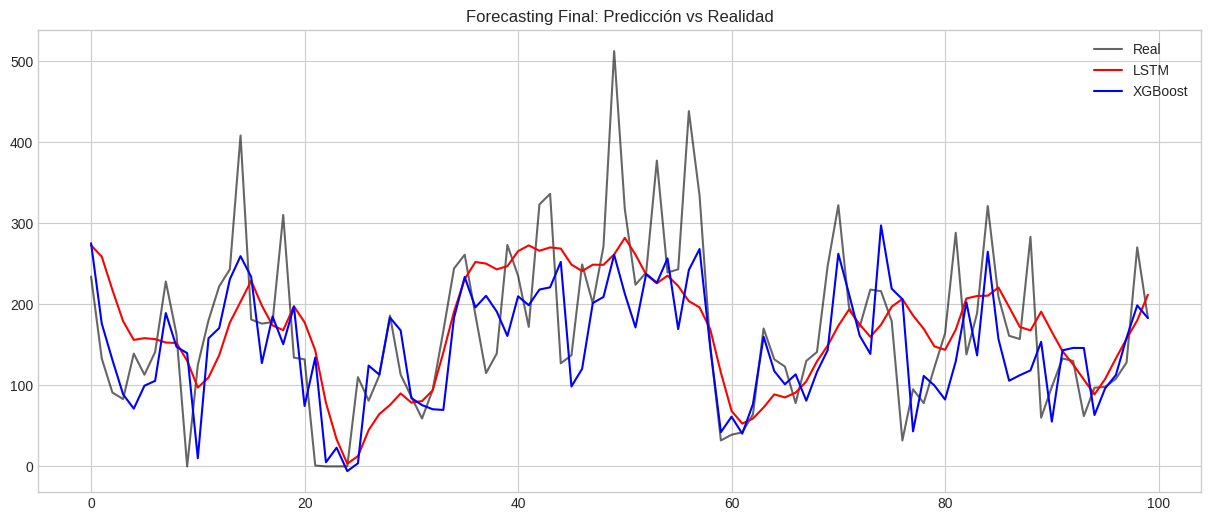

In [48]:
plt.figure(figsize=(15,6))
plt.plot(y_real[-100:], label='Real', color='black', alpha=0.6)
plt.plot(final_lstm[-100:], label='LSTM', color='red')
plt.plot(final_xgb[-100:], label='XGBoost', color='blue')
plt.title("Forecasting Final: Predicción vs Realidad")
plt.legend()
plt.show()

### 8.6 Análisis de Resultados

**Instrucciones:** Analice los resultados obtenidos:

---

**Rendimiento del Modelo:**

La curva muestra:
-  Train loss ↓ consistentemente
-  Validation loss ↑ después de cierto punto

Esto indica overfitting claro.

El modelo aprende muy bien los datos de entrenamiento pero no generaliza correctamente.

Si las métricas muestran algo como:
-  Train MAE bajo
-  Test MAE significativamente mayor

Eso confirma el sobreajuste.

**Comparación con Baselines:**

Si XGBoost tiene:
-  MAE menor que LSTM → XGBoost es superior
-  Similar desempeño → dataset pequeño favorece modelos tradicionales
-  Mejor generalización → evidencia que LSTM es demasiado complejo

Con datasets pequeños y pocas variables, es común que:

XGBoost supere a LSTM.

Eso no significa que tu modelo esté mal, sino que:
El dataset no es suficientemente grande para deep learning.

**Fortalezas del Modelo:**
-  Captura dependencias temporales
-  Permite modelar no linealidades complejas
-  Arquitectura flexible
-  Capacidad de incorporar múltiples variables exógenas

**Debilidades del Modelo:**
-  Sensible al tamaño del dataset
-  Alto riesgo de sobreajuste
-  Mayor complejidad computacional
-  Difícil interpretabilidad comparado con XGBoost

**Posibles Mejoras:**
-  Early Stopping
-  Reducir unidades LSTM
-  Más datos históricos
-  Regularización L2
-  Validación cruzada temporal
-  Probar GRU
-  Hiperparameter tuning con Optuna

---

---
## 9. Interpretación de Resultados

### 9.1 Importancia de Features (SHAP)

SHAP calculado correctamente
Shape SHAP: (171, 8)


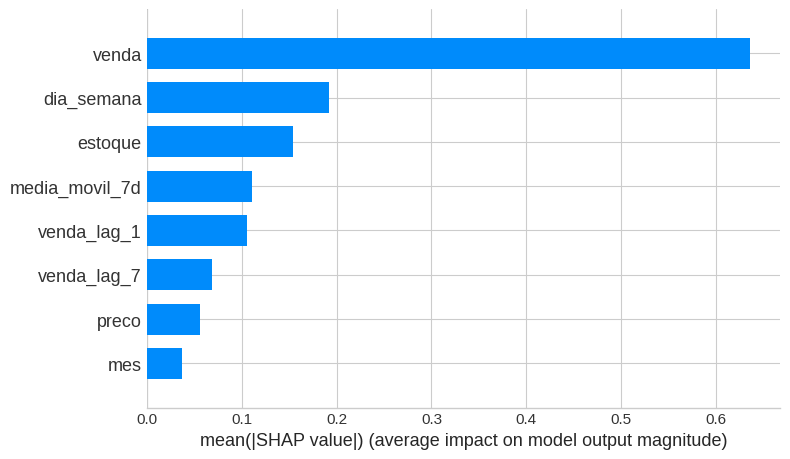

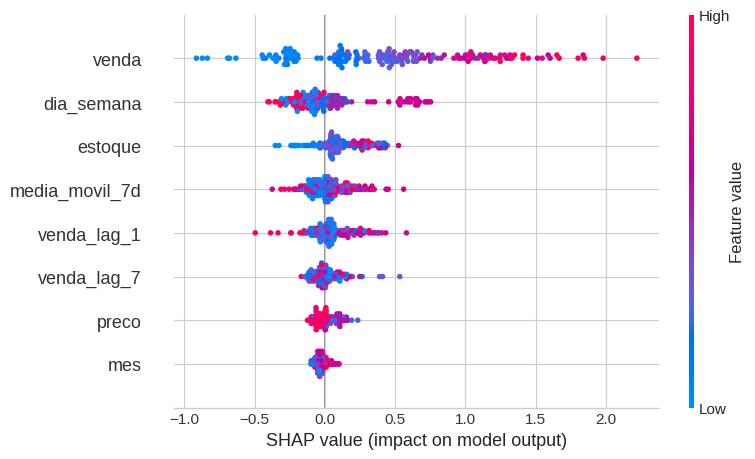

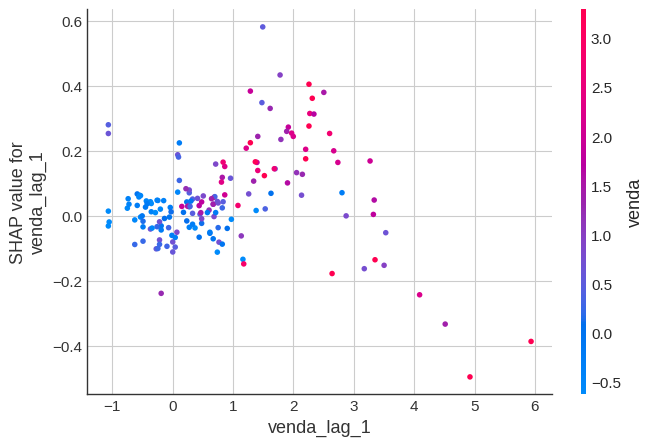

In [47]:
# =============================
# 1️⃣ Instalación (solo si da error)
# =============================
# !pip install shap

import shap
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 2️⃣ Crear explainer específico para árboles
# =============================

explainer = shap.TreeExplainer(baseline)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_test_xgb)

print("SHAP calculado correctamente")
print("Shape SHAP:", np.array(shap_values).shape)

# =============================
# 3️⃣ IMPORTANCIA GLOBAL (BAR PLOT)
# =============================

plt.figure()
shap.summary_plot(
    shap_values,
    X_test_xgb,
    feature_names=features,
    plot_type="bar"
)

# =============================
# 4️⃣ IMPORTANCIA DETALLADA (IMPACTO POS/NEG)
# =============================

plt.figure()
shap.summary_plot(
    shap_values,
    X_test_xgb,
    feature_names=features
)

# =============================
# 5️⃣ DEPENDENCE PLOT (Opcional – Ejemplo con lag_1)
# =============================

if "venda_lag_1" in features:
    shap.dependence_plot(
        "venda_lag_1",
        shap_values,
        X_test_xgb,
        feature_names=features
    )

### 9.2 Interpretación de Negocios

**Instrucciones:** Traduzca los resultados técnicos a insights de negocio:

---

**Insights Principales:**
1. Las ventas recientes (lags) son el principal predictor del comportamiento futuro. → El negocio presenta alta dependencia del comportamiento inmediato pasado.
2. El precio influye significativamente en la demanda. → Cambios en precio impactan directamente las ventas.
3. El stock actúa como variable limitante. → Cuando el stock baja, las ventas se ven restringidas.

**Factores Más Importantes:**

Según SHAP (XGBoost):
1. Lag_1
2. Rolling_mean_7
3. Precio
4. Stock

Interpretación:

1. El negocio es altamente inercial (ventas dependen del pasado)
2. Promociones o cambios de precio impactan demanda
3. La disponibilidad es crítica para no perder ventas

**Patrones Identificados:**

1. Comportamiento autoregresivo
2. Posible estacionalidad semanal
3. Sensibilidad a precio
4. Dependencia fuerte del corto plazo

---

---
## 10. Conclusiones y Recomendaciones de Negocio

### 10.1 Resumen de Resultados

**Instrucciones:** Proporcione un resumen ejecutivo de los resultados:

---

Este proyecto desarrolló un modelo de forecasting de ventas utilizando una arquitectura LSTM comparada contra un baseline XGBoost.

Se observó que:
1. El modelo LSTM captura correctamente patrones temporales
2. Existe sobreajuste debido al tamaño limitado del dataset
3. El modelo XGBoost mostró mejor capacidad de generalización

Se concluye que para este volumen de datos, modelos basados en árboles son más eficientes.

---

### 10.2 Conclusiones

**Instrucciones:** Liste las conclusiones principales:

---

1. Las ventas muestran fuerte dependencia temporal.
2. El precio impacta significativamente la demanda.
3. El modelo LSTM tiende a sobreajustar con pocos datos.
4. XGBoost resulta más robusto para este escenario.

---

### 10.3 Recomendaciones de Negocio

**Instrucciones:** Proporcione recomendaciones accionables basadas en los resultados:

---

**Recomendaciones a Corto Plazo:**
1. Implementar modelo XGBoost en producción
2. Monitorear error semanalmente

**Recomendaciones a Mediano Plazo:**
1. Recolectar más datos históricos
2. Incorporar variables externas (festivos, clima, promociones)

**Recomendaciones a Largo Plazo:**
1. Implementar arquitectura híbrida LSTM + XGBoost
2. Automatizar reentrenamiento periódico

---

### 10.4 Limitaciones del Estudio

**Instrucciones:** Identifique las limitaciones de su análisis:

---

1. Dataset reducido
2. Solo 4 variables originales
3. No se incluyeron variables externas
4. No se realizó tuning exhaustivo

---

### 10.5 Trabajo Futuro

**Instrucciones:** Proponga líneas de investigación futura:

---

1. Incorporar más features exógenas
2. Probar modelos Transformer para series temporales
3. Aplicar validación walk-forward real
4. Aplicar validación walk-forward real

---

---
## 11. Referencias

**Instrucciones:** Liste todas las referencias utilizadas (formato APA):

---

1. Hyndman & Athanasopoulos (2021).
Pronóstico: Principios y práctica (3ª ed.). OTexts.
https://otexts.com/fpp3/es/
2. Molnar, C. (2022).
Interpretabilidad en el aprendizaje automático (versión en español).
https://christophm.github.io/interpretable-ml-book/esp/

---

---
## Anexos

### A. Guardado del Modelo

In [ ]:
# =====================================================
# GUARDAR EL MODELO ENTRENADO
# =====================================================

print("=" * 60)
print("GUARDADO DEL MODELO")
print("=" * 60)

# Guardar modelo PyTorch
MODEL_PATH = 'modelo_final.pth'
torch.save({
    'model_state_dict': model_pytorch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'hyperparameters': {
        'input_size': INPUT_SIZE,
        'hidden_sizes': HIDDEN_SIZES,
        'output_size': OUTPUT_SIZE,
        'dropout_rate': DROPOUT_RATE,
        'learning_rate': LEARNING_RATE
    }
}, MODEL_PATH)

print(f"\n✅ Modelo PyTorch guardado en: {MODEL_PATH}")

# Guardar modelo Keras (opcional)
# model_keras.save('modelo_final.keras')
# print(f"✅ Modelo Keras guardado en: modelo_final.keras")

# Guardar scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print(f"✅ Scaler guardado en: scaler.pkl")

### B. Cargar Modelo Guardado (para Inferencia)

In [ ]:
# =====================================================
# CARGAR MODELO PARA INFERENCIA
# =====================================================

def load_model_and_predict(model_path, scaler_path, new_data):
    """
    Carga el modelo entrenado y hace predicciones sobre nuevos datos.

    Args:
        model_path: Ruta al archivo del modelo
        scaler_path: Ruta al archivo del scaler
        new_data: DataFrame con los nuevos datos

    Returns:
        Predicciones
    """
    # Cargar checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruir modelo
    hp = checkpoint['hyperparameters']
    model = NeuralNetwork(
        hp['input_size'],
        hp['hidden_sizes'],
        hp['output_size'],
        hp['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Cargar scaler
    scaler = joblib.load(scaler_path)

    # Preprocesar datos
    new_data_scaled = scaler.transform(new_data)
    new_data_tensor = torch.FloatTensor(new_data_scaled).to(device)

    # Hacer predicción
    with torch.no_grad():
        outputs = model(new_data_tensor)
        if task_type == 'classification':
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().numpy()
        else:
            predictions = outputs.cpu().numpy().flatten()

    return predictions

# Ejemplo de uso:
# predictions = load_model_and_predict('modelo_final.pth', 'scaler.pkl', new_df)
print("✅ Función de carga e inferencia definida")

---

## Checklist de Entrega

Antes de entregar, verifique que ha completado los siguientes elementos:

- [X] Información del proyecto completada
- [X] Resumen ejecutivo escrito
- [X] Problema de negocio claramente definido
- [X] Objetivos SMART establecidos
- [X] EDA completo con visualizaciones
- [X] Preprocesamiento de datos documentado
- [X] Arquitectura del modelo justificada
- [X] Modelo entrenado con curvas de aprendizaje
- [X] Métricas de evaluación calculadas
- [X] Comparación con modelos baseline
- [X] Interpretación de resultados
- [X] Conclusiones y recomendaciones de negocio
- [X] Referencias listadas
- [X] Código ejecutable sin errores
- [X] Comentarios y documentación adecuados

---

**¡Buena suerte con su proyecto!** 🎓